In [37]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import concurrent.futures
import requests
import itertools
import networkx as nx
from collections import defaultdict
from functools import partial
import aiohttp
import asyncio
from tqdm import tqdm
from requests_futures.sessions import FuturesSession

headers = {"accept": "application/json"}
api_key = "f5813332cb558d374cbcb057ea2fc48b"

In [38]:
def movie_titles_and_IDs_from_actor_ID(actor_id, session):
    url = f"https://api.themoviedb.org/3/person/{actor_id}/movie_credits?api_key={api_key}"
    response = session.get(url)
    data = response.json()
    # Return the whole movie dictionary, not just the title
    return [movie['title'] for movie in data['cast']], [movie['id'] for movie in data['cast']]

In [39]:
def fetch_page(page, session):
    url = f"https://api.themoviedb.org/3/person/popular?api_key={api_key}&page={page}"
    response = session.get(url)
    data = response.json()
    people = []
    for person in data['results']:
        person_url = f"https://api.themoviedb.org/3/person/{person['id']}?api_key={api_key}"
        person_response = session.get(person_url)
        person_data = person_response.json()
        people.append((person['name'], person['id'], person_data['gender'], person_data['birthday'], person_data['place_of_birth']))
    return people

with requests.Session() as session:
    session.headers.update(headers)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        pages = list(range(1, 101))
        fetch_page_with_session = partial(fetch_page, session=session)
        people = list(executor.map(fetch_page_with_session, pages))

all_people_names, all_people_ids, all_people_genders, all_people_birthdays, all_people_birthplaces = zip(*itertools.chain(*people))

In [43]:
# Create a DataFrame with 'actors' column
df_actors = pd.DataFrame(all_people_names, columns=['actors'])

# Add 'ids', 'genders', and 'birthplaces' columns to the DataFrame
df_actors['actor_ids'] = all_people_ids
df_actors['genders'] = all_people_genders
df_actors['ages'] = all_people_birthdays # This is not the age, but the birthday
df_actors['birthplaces'] = all_people_birthplaces

# Change birthday to age
df_actors['ages'] = pd.to_datetime(df_actors['ages'], errors='coerce')
df_actors['ages'] = (pd.to_datetime('today') - df_actors['ages']).dt.days // 365

# Drop rows with missing values
df_actors.dropna(inplace=True)

# Drop duplicates
df_actors.drop_duplicates(subset='actors', inplace=True)
#reset index
df_actors.reset_index(drop=True, inplace=True)


In [44]:
df_actors

,actors,actor_ids,genders,ages,birthplaces
0,Jessica Gunning,1196101,1,38.0,"Holmfirth, West Yorkshire, United Kingdom"
1,Kevin Willmott,91585,2,64.0,"Junction City, Kansas, USA"
2,Ella Purnell,989325,1,27.0,"London, England, UK"
3,Sydney Sweeney,115440,1,26.0,"Spokane, Washington, USA"
4,Jason Statham,976,2,56.0,"Shirebrook, Derbyshire, England, UK"
...,...,...,...,...,...
1731,Tuba Büyüküstün,142855,1,41.0,"Istanbul, Turkey"
1732,Eli Roth,16847,2,52.0,"Newton, Massachusetts, USA"
1733,Lainey Silver,2581975,1,36.0,"Paso Robles, California, USA"
1734,Tracey Walter,3801,2,76.0,"Jersey City, New Jersey, USA"


In [46]:
# Fetch movies for each actor and add them to 'movies' and 'movie_IDs' columns
with requests.Session() as session:
    session.headers.update(headers)
    movie_titles_and_ids_from_actor_ID_with_session = partial(movie_titles_and_IDs_from_actor_ID, session=session)
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        movies_and_ids = list(executor.map(movie_titles_and_ids_from_actor_ID_with_session, df_actors['actor_ids']))

# Add 'movies' column to df_actors
df_actors['movies'] = [x[0] for x in movies_and_ids]

# Flatten movies_and_ids into two separate lists
movies = [item for sublist in [x[0] for x in movies_and_ids] for item in sublist]
ids = [item for sublist in [x[1] for x in movies_and_ids] for item in sublist]

# Convert the lists into a list of dictionaries
movies_and_ids_dict = [{'movie': movie, 'movie_ID': id} for movie, id in zip(movies, ids)]

# Convert the list of dictionaries into a DataFrame
movies_df = pd.DataFrame(movies_and_ids_dict)
movies_df = movies_df.drop_duplicates()
movies_df.reset_index(drop=True, inplace=True)

In [47]:
movies_df

,movie,movie_ID
0,Pride,234200
1,Ghost in the Machine,399570
2,Love Is Thicker Than Water,347024
3,The Scandalous Lady W,352733
4,Lizzie and Sarah,355072
...,...,...
50726,Good Luck Chuck,10030
50727,P.U.N.K.S,62410
50728,Venus Rising,115284
50729,Dear Eleanor,253343


In [48]:
def fetch(session, url):
    future = session.get(url, headers=headers)
    return future

def fetch_all(urls):
    with FuturesSession() as session:
        futures = [fetch(session, url) for url in urls]
        responses = [future.result().json() for future in futures]
    return responses

In [49]:
# Prepare the URLs
urls = [f"https://api.themoviedb.org/3/movie/{id}?api_key={api_key}" for id in movies_df["movie_ID"]]

# Fetch all responses
responses = fetch_all(urls)

# Process the responses
for response in responses:
    if isinstance(response, Exception):
        print(f"Error: {response}")
        continue  # Skip this response
    # Process the response here

# Initialize empty lists to store the data
ratings = []
popularities = []
genres = []
release_dates = []
abstracts = []

# Process the responses one by one
for data in tqdm(responses):
    ratings.append(data.get('vote_average'))
    popularities.append(data.get('popularity'))
    genres.append([genre['name'] for genre in data.get('genres', [])])
    release_dates.append(data.get('release_date'))
    abstracts.append(data.get('overview'))
    
# Assign the lists to the DataFrame columns
movies_df['rating'] = ratings
movies_df['popularity'] = popularities
movies_df['genres'] = genres
movies_df['release_date'] = release_dates
movies_df['abstract'] = abstracts

100%|██████████| 50731/50731 [00:00<00:00, 187485.83it/s]


In [50]:
movies_df

,movie,movie_ID,rating,popularity,genres,release_date,abstract
0,Pride,234200,7.700,30.990,"[Drama, Comedy]",2014-09-12,"In 1984, a group of LGBT activists decide to r..."
1,Ghost in the Machine,399570,0.000,1.000,"[Drama, Fantasy]",2012-11-02,Lonely Noreen daydreams of being whisked away ...
2,Love Is Thicker Than Water,347024,6.800,4.219,"[Romance, Comedy, Drama]",2017-08-31,Vida and Arthur come from vastly different bac...
3,The Scandalous Lady W,352733,6.600,6.457,"[Drama, TV Movie, Romance, History]",2015-08-17,A gripping 18th century drama details the scan...
4,Lizzie and Sarah,355072,7.400,1.369,[],2010-03-20,Lizzie and Sarah are two fiftysomething suburb...
...,...,...,...,...,...,...,...
50726,Good Luck Chuck,10030,5.918,23.580,"[Comedy, Romance]",2007-09-21,"Cursed since childhood, dentist Charlie Logan ..."
50727,P.U.N.K.S,62410,5.200,2.656,"[Comedy, Family, Science Fiction, TV Movie]",1999-01-05,"Drew Utley, Miles Kitchen, Lanny Nygren and Jo..."
50728,Venus Rising,115284,2.000,10.781,"[Thriller, Science Fiction]",1995-11-30,A couple escapes an island prison and are chas...
50729,Dear Eleanor,253343,5.956,18.215,"[Adventure, Comedy, Drama]",2016-07-05,Two teenage girls travel across the U.S. in 19...


In [51]:
# Drop duplicates
movies_df.drop_duplicates(subset='movie', inplace=True)

# Drop rows with missing values
movies_df.dropna(inplace=True)

# Remove rows with empty lists in 'genres' column
movies_df = movies_df[movies_df['genres'].apply(lambda x: len(x) > 0)]

# Remove rows with empty release dates
movies_df = movies_df[movies_df['release_date'].apply(lambda x: len(x) > 0)]

# Drop row if abstract is missing
movies_df = movies_df[movies_df['abstract'].apply(lambda x: len(x) > 0)]

# Drop row if rating is missing
movies_df = movies_df[movies_df['rating'].apply(lambda x: x > 0)]

# Drop row if popularity is missing
movies_df = movies_df[movies_df['popularity'].apply(lambda x: x > 0)]

# Reset index
movies_df.reset_index(drop=True, inplace=True)

In [52]:
movies_df

,movie,movie_ID,rating,popularity,genres,release_date,abstract
0,Pride,234200,7.700,30.990,"[Drama, Comedy]",2014-09-12,"In 1984, a group of LGBT activists decide to r..."
1,Love Is Thicker Than Water,347024,6.800,4.219,"[Romance, Comedy, Drama]",2017-08-31,Vida and Arthur come from vastly different bac...
2,The Scandalous Lady W,352733,6.600,6.457,"[Drama, TV Movie, Romance, History]",2015-08-17,A gripping 18th century drama details the scan...
3,That Day We Sang,313783,6.500,3.600,"[Drama, Music, TV Movie]",2014-12-26,TV Film adaptation of Victoria Wood's hit musi...
4,Summerland,523977,7.600,32.034,"[Drama, Romance]",2020-07-24,A woman during the Second World War opens her ...
...,...,...,...,...,...,...,...
37631,Honey,10028,6.300,40.806,"[Music, Drama, Romance]",2003-11-24,Honey Daniels dreams of making a name for hers...
37632,Good Luck Chuck,10030,5.918,23.580,"[Comedy, Romance]",2007-09-21,"Cursed since childhood, dentist Charlie Logan ..."
37633,P.U.N.K.S,62410,5.200,2.656,"[Comedy, Family, Science Fiction, TV Movie]",1999-01-05,"Drew Utley, Miles Kitchen, Lanny Nygren and Jo..."
37634,Venus Rising,115284,2.000,10.781,"[Thriller, Science Fiction]",1995-11-30,A couple escapes an island prison and are chas...


In [53]:
# Combine the two dataframes so that each actor is associated with the movies they have acted in
df_actors_filtered = df_actors.copy()
df_movies_filtered = movies_df.copy()
df_movies_filtered.rename(columns={'movie': 'movies'}, inplace=True)

df_actors_filtered = df_actors_filtered.explode('movies').reset_index(drop=True)

df_actors_movies = df_actors_filtered.merge(df_movies_filtered, on='movies', how='left')

# Remove all rows where the release date is before 2010
df_actors_movies = df_actors_movies[(df_actors_movies['release_date'] >= '2010-01-01') & (df_actors_movies['release_date'] <= '2024-04-16')]

# Collapse the the actors in the actor column so there is only one row per actor and the movies and movie_IDs are stored in lists
df_actors_filtered = df_actors_movies.groupby('actors').agg({'actor_ids': 'first',
                                                             'genders': 'first',
                                                             'birthplaces': 'first',
                                                             'ages': 'first',
                                                             'movies': list, 
                                                             'movie_ID': list}).reset_index()

df_movies_filtered = df_actors_movies.drop_duplicates(subset=['movies']).groupby('movies').agg({'movie_ID': 'first',
                                                                                               'rating': 'first',
                                                                                               'popularity': 'first',
                                                                                               'genres': 'first',
                                                                                               'release_date': 'first',
                                                                                               'abstract': 'first'}).reset_index()

In [54]:
df_actors_filtered

,actors,actor_ids,genders,birthplaces,ages,movies,movie_ID
0,AJ Raval,2948828,1,"Manila, Philippines",23.0,"[Paglaki Ko, Gusto Kong Maging Pornstar, Death...","[789474.0, 814082.0, 851274.0, 860306.0, 87348..."
1,Aaron Eckhart,6383,2,"Cupertino, California, USA",56.0,"[The Rum Diary, Rabbit Hole, Battle: Los Angel...","[23514.0, 27585.0, 44943.0, 100241.0, 106021.0..."
2,Aaron Moten,1386221,2,"Austin, Texas, USA",35.0,"[Ricki and the Flash, Ironwood, Native Son, Th...","[275601.0, 517450.0, 512199.0, 392818.0, 71593..."
3,Aaron Paul,84497,2,"Emmett, Idaho, USA",44.0,"[Eye in the Sky, Wreckage, Smashed, A Long Way...","[333352.0, 73085.0, 84341.0, 141043.0, 145174...."
4,Aaron Taylor-Johnson,27428,2,"High Wycombe, Buckinghamshire, England, UK",33.0,"[Kick-Ass, Chatroom, Savages, Kick-Ass 2, Anna...","[23483.0, 48946.0, 82525.0, 59859.0, 96724.0, ..."
...,...,...,...,...,...,...,...
1698,Zoë Kravitz,37153,1,"Los Angeles, California, USA",35.0,"[Twelve, It's Kind of a Funny Story, After Ear...","[40720.0, 43923.0, 82700.0, 75090.0, 150065.0,..."
1699,Özge Gürel,1445027,1,"Istanbul, Turkey",37.0,"[Our Hodja, My Mother, Red Snow]","[289424.0, 630191.0, 745537.0]"
1700,Öznur Serçeler,1760504,1,"Kayseri, Türkiye",37.0,"[Everything Is Love, Deccal, Is This Love?, Re...","[442392.0, 353166.0, 613976.0, 952062.0, 32003..."
1701,Úrsula Corberó,1042728,1,"Barcelona, Catalonia, Spain",34.0,"[Paranormal Xperience, Who Killed Bambi?, Off ...","[85438.0, 217414.0, 264729.0, 613486.0, 278736..."


In [55]:
df_movies_filtered

,movies,movie_ID,rating,popularity,genres,release_date,abstract
0,"""That's Awesome!"": The Story of 'Dumb and Dumb...",336076.0,7.500,2.819,"[Documentary, Comedy]",2015-02-17,"An expansive, five-part 45 minute making-of wi..."
1,#ALLMYMOVIES,368247.0,7.500,2.744,[Documentary],2015-11-12,Shia LaBeouf watches all his movies in reverse...
2,#AnneFrank. Parallel Stories,610643.0,7.100,6.269,"[Documentary, Drama, History]",2019-10-18,One single Anne Frank moves us more than the c...
3,#DoYouThinkIAmSexy?,1014843.0,4.000,9.307,"[Drama, Thriller]",2022-09-09,Charlize supports her studies by creating sexy...
4,#FBF,828434.0,5.700,14.519,[Drama],2022-03-31,Teenage Annie inadvertently takes her mother's...
...,...,...,...,...,...,...,...
15176,xXx: Return of Xander Cage,47971.0,6.132,85.139,"[Action, Adventure, Crime]",2017-01-13,Extreme athlete turned government operative Xa...
15177,Ánima,416185.0,5.300,2.725,"[Drama, Romance]",2011-07-08,Julieta takes her cello to a luthier's worksho...
15178,Ødeland,412099.0,8.000,5.620,"[Drama, Science Fiction]",2015-03-27,"In a post-apocalyptic world in human decay, a ..."
15179,Übermansion,639275.0,10.000,4.518,"[Animation, Comedy]",2013-08-25,A group of superheroes live in a mansion where...


In [57]:
# save the dataframes to csv files
df_actors_filtered.to_csv('data/actors.csv', index=False)
df_movies_filtered.to_csv('data/movies.csv', index=False)

### Creating the network

In [ ]:
# load the dataframes from csv files
df_actors_filtered = pd.read_csv('data/actors.csv')
df_movies_filtered = pd.read_csv('data/movies.csv')

In [56]:
# Step 1: Prepare the Data
movie_to_actors = defaultdict(list)

for _ , row in df_actors_filtered.iterrows():
    actor = row['actors']
    movies = row['movies']
    for movie in movies:
        movie_to_actors[movie].append(actor)

edges = defaultdict(int)
for actors in movie_to_actors.values():
    for pair in itertools.combinations(sorted(actors), 2):
        edges[pair] += 1

# Step 2: Create the Graph
G = nx.Graph()

# Add nodes with attributes
for _ , row in df_actors_filtered.iterrows():
    G.add_node(row['actors'], gender=row['genders'], age=row['ages'], birthplace=row['birthplaces'])

# Add edges with weights
for edge, weight in edges.items():

# YAHNI
    if weight >= 2:
        G.add_edge(*edge, weight=weight)

# Step 3: Analyze the Graph
degrees = dict(G.degree(weight='weight'))
most_connected_actors = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

In [34]:
print(G)

Graph with 75 nodes and 384 edges


### Initial network analysis

In [36]:
# Sort the edges by weight in descending order
sorted_edges = sorted(G.edges.data(), key=lambda x: x[2]['weight'], reverse=True)

# Print the top 10 edges with the highest weights
for i, edge in enumerate(sorted_edges[:10], start=1):
    print(f"Rank: {i}, Edge: {edge[0]} - {edge[1]}, Weight: {edge[2]['weight']}")

Rank: 1, Edge: Dwayne Johnson - John Cena, Weight: 34
Rank: 2, Edge: Clint Eastwood - Morgan Freeman, Weight: 7
Rank: 3, Edge: Jason Statham - Sylvester Stallone, Weight: 7
Rank: 4, Edge: Karen Gillan - Vin Diesel, Weight: 7
Rank: 5, Edge: Brad Pitt - Matt Damon, Weight: 5
Rank: 6, Edge: Dwayne Johnson - Kevin Hart, Weight: 5
Rank: 7, Edge: Dwayne Johnson - Jason Statham, Weight: 5
Rank: 8, Edge: Dwayne Johnson - Vin Diesel, Weight: 5
Rank: 9, Edge: Jason Statham - Vin Diesel, Weight: 5
Rank: 10, Edge: Tom Holland - Zendaya, Weight: 5


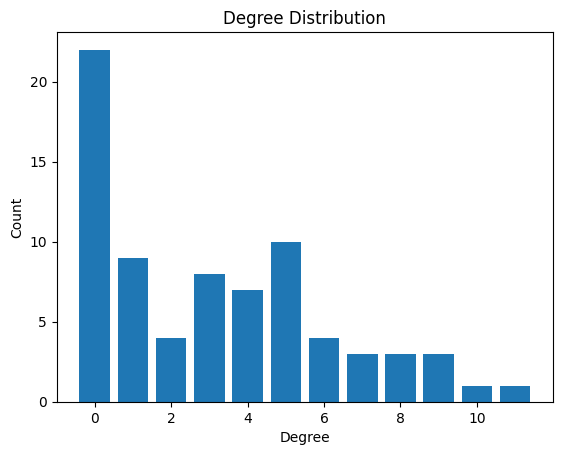

In [29]:
# Calculate degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=False)  # sort in ascending order
degree_count = nx.degree_histogram(G)

# Plot degree distribution
plt.bar(range(len(degree_count)), degree_count, align='center')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.show()


Text(0.5, 1.0, 'Degree Distribution (log scale)')

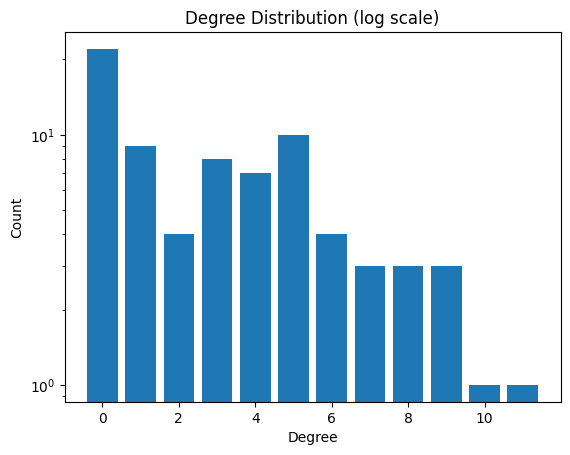

In [30]:
#make a log plot
plt.bar(range(len(degree_count)), degree_count, align='center')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution (log scale)')

In [31]:
# Plot with netwulf
import netwulf as nw

nw.visualize(G)


(None, None)

### Network analysis

In [ ]:
# Calculate the degree assortativity coefficient
assortativity = nx.degree_assortativity_coefficient(G)

In [ ]:
# 